# Thống kê máy tính và ứng dụng (Computational Statistics and Applications)

**Khoa Công nghệ Thông tin - ĐH Khoa học Tự nhiên TP. HCM ([fit@hcmus](https://www.fit.hcmus.edu.vn/))**

*Vũ Quốc Hoàng (vqhoang@fit.hcmus.edu.vn)*

# Bài 6 - Thống kê Bayes tính toán và Lập trình xác suất

**Nội dung**

* [Lập trình xác suất](#lap_trinh_xac_suat)
  * [Ví dụ 1](#xs_vd1)
  * [Ví dụ 2](#xs_vd2)
  * [Ví dụ 3](#xs_vd3)
  * [Ví dụ 4](#xs_vd4)
* [So sánh nhóm](#so_sanh)
* [Suy luận kháng ngoại lai](#khang)
* [Mô hình phân cấp](#phan_cap)
* [Mô hình tuyến tính tổng quát](#tuyen_tinh)
  * [Ví dụ 1](#tt_vd1)
  * [Ví dụ 2](#tt_vd2)

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

## <a name="lap_trinh_xac_suat"/>Lập trình xác suất


* [PyMC](https://www.pymc.io/welcome.html)
* [ArviZ](https://python.arviz.org/en/stable/)

### <a name="xs_vd1"/>Ví dụ 1

Đặc tả mô hình và suy diễn tự động.

In [2]:
import pytensor

x = np.array([1.77, 2.23, 2.70])
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
sigma2s = [1, 1.35, 2]
traces = []
models = []

for sigma2 in sigma2s:
  with pm.Model() as model:
    models.append(model)
    mu_index_var = pm.Categorical("mu_index", p=prior)
    mu_var = pytensor.shared(mu)[mu_index_var]
    x_var = pm.Normal("x", mu=mu_var, tau=1/sigma2, observed=x)
    traces.append(pm.sample(draws=5000, return_inferencedata=False))

Output()

Output()

Output()

Phân phối hậu nghiệm.

In [3]:
series = []
for i, sigma2 in enumerate(sigma2s):
  mu_index_posterior = traces[i]["mu_index"]
  values, counts = np.unique(mu_index_posterior, return_counts=True)
  serie = pd.Series(np.zeros_like(mu), index=mu, name=sigma2)
  for j in range(len(values)):
    serie[mu[values[j]]] = counts[j]/np.sum(counts)
  series.append(serie)

pd.concat(series, axis=1)

,1.00,1.35,2.00
1.0,0.0718,0.1103,0.1588
2.0,0.6438,0.5543,0.4789
3.0,0.2780,0.3171,0.3156
4.0,0.0064,0.0183,0.0467


Phân phối dự đoán hậu nghiệm.

Output()

Output()

Output()

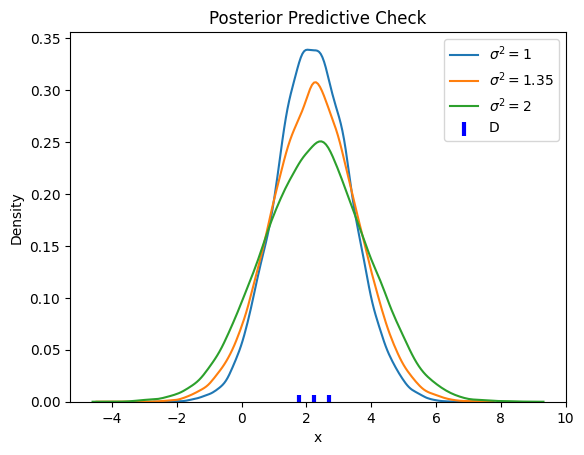

In [4]:
for i, sigma2 in enumerate(sigma2s):
  x_post_sample = pm.sample_posterior_predictive(traces[i], models[i], return_inferencedata=False)["x"].flatten()
  sns.kdeplot(x_post_sample, label=f"$\sigma^2 = {sigma2}$")

plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("x")
plt.show()

Kết quả cho thấy các giả thuyết về mô hình phù hợp với dữ liệu.

Thử nghiệm với $\sigma^2$ nhỏ (giả thuyết sai số các quả bóng nhỏ).

In [5]:
sigma2s = [0.01, 0.05, 0.1]
traces = []
models = []

for sigma2 in sigma2s:
  with pm.Model() as model:
    models.append(model)
    mu_index_var = pm.Categorical("mu_index", p=prior)
    mu_var = pytensor.shared(mu)[mu_index_var]
    x_var = pm.Normal("x", mu=mu_var, tau=1/sigma2, observed=x)
    traces.append(pm.sample(draws=5000, return_inferencedata=False))

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Output()

In [6]:
series = []
for i, sigma2 in enumerate(sigma2s):
  mu_index_posterior = traces[i]["mu_index"]
  values, counts = np.unique(mu_index_posterior, return_counts=True)
  serie = pd.Series(np.zeros_like(mu), index=mu, name=sigma2)
  for j in range(len(values)):
    serie[mu[values[j]]] = counts[j]/np.sum(counts)
  series.append(serie)

pd.concat(series, axis=1)

,0.01,0.05,0.10
1.0,0.0,0.0,0.0000
2.0,1.0,1.0,0.9995
3.0,0.0,0.0,0.0005
4.0,0.0,0.0,0.0000


Output()

Output()

Output()

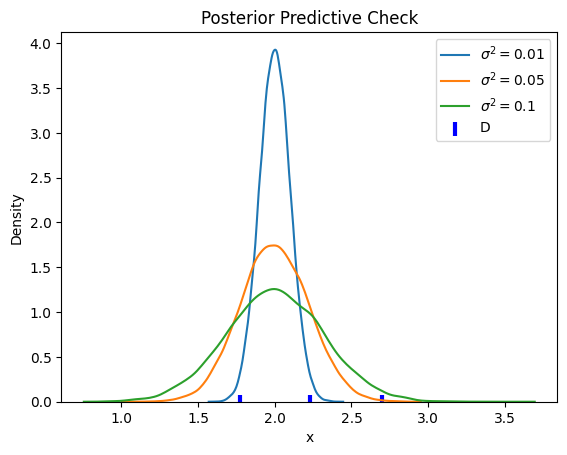

In [7]:
for i, sigma2 in enumerate(sigma2s):
  x_post_sample = pm.sample_posterior_predictive(traces[i], models[i], return_inferencedata=False)["x"].flatten()
  sns.kdeplot(x_post_sample, label=f"$\sigma^2 = {sigma2}$")

plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("x")
plt.show()

Từ phân phối hậu nghiệm dự đoán ta thấy nếu $\sigma^2$ nhỏ thì các giả thuyết của mô hình không còn phù hợp với dữ liệu. Cần xem xét lại các giả thuyết (hoặc dữ liệu không đúng).

### <a name="xs_vd2"/>Ví dụ 2

Mô hình nhị thức

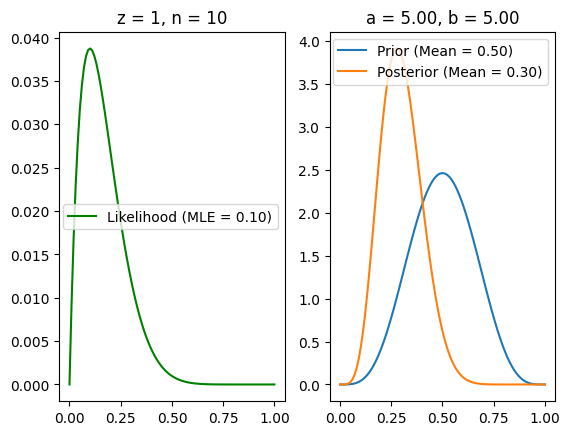

In [8]:
a, b = 5, 5
z, n = 1, 10

theta = np.linspace(0, 1, 100)
likelihood = theta**z * (1 - theta)**(n - z)
prior_dist = stats.beta(a, b)
posterior_dist = stats.beta(a + z, b + n - z)
prior = prior_dist.pdf(theta)
posterior = posterior_dist.pdf(theta)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label="Likelihood (MLE = %.2f)" % (z/n))
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label="Prior (Mean = %.2f)" % prior_dist.mean())
ax2.plot(theta, posterior, label="Posterior (Mean = %.2f)" % posterior_dist.mean())
ax2.set_title("a = %.2f, b = %.2f" % (a, b))
ax2.legend()
plt.show()

Dùng PyMC

In [9]:
with pm.Model() as model:
    theta = pm.Beta("theta", alpha=a, beta=b)
    z_var = pm.Binomial("z", p=theta, n=n, observed=z)
    trace = pm.sample(5000)
    prior_pred = pm.sample_prior_predictive(1000, return_inferencedata=False)
    posterior_pred = pm.sample_posterior_predictive(trace, return_inferencedata=False)

Output()

Output()

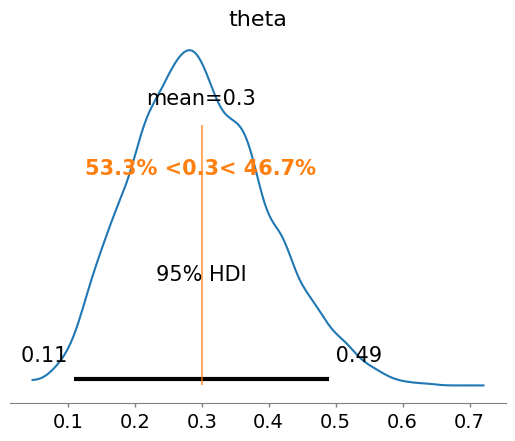

In [10]:
with model:
    az.plot_posterior(trace, var_names=["theta"], hdi_prob=0.95, ref_val=posterior_dist.mean())
    plt.show()

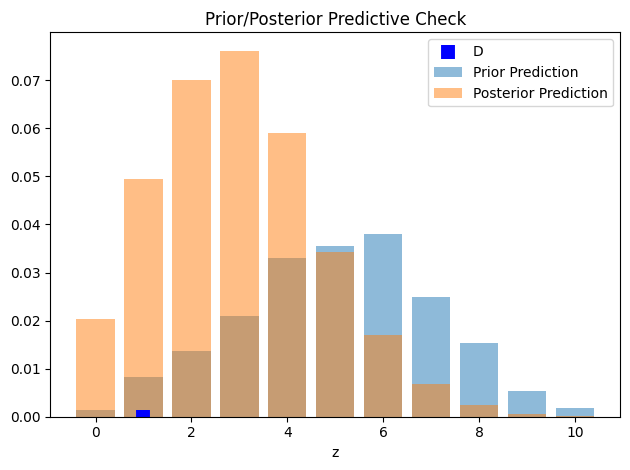

In [11]:
prior_values, prior_counts = np.unique(prior_pred["z"], return_counts=True)
posterior_values, posterior_counts = np.unique(posterior_pred["z"].flatten(), return_counts=True)

plt.bar(prior_values, prior_counts/np.sum(prior_pred["z"]), label="Prior Prediction", alpha=0.5)
plt.bar(posterior_values, posterior_counts/np.sum(posterior_pred["z"].flatten()),
        label="Posterior Prediction", alpha=0.5)
plt.scatter(z, 0, s=100, marker='|', color='b', linewidths=10, label="D")
plt.legend()
plt.title("Prior/Posterior Predictive Check")
plt.xlabel("z")
plt.tight_layout()

plt.show()

### <a name="xs_vd3"/>Ví dụ 3

Cho
\begin{align*}
      X &\sim \mathcal{N}(0, 1),\\
      Y &\sim \mathcal{N}(X, 1).
\end{align*}
Ta có
$$
P(X \ge 0|Y = y) = 1 - \Phi\left(\frac{-y}{\sqrt{2}}\right).
$$

In [12]:
y = 2
1 - stats.norm().cdf(-y/np.sqrt(2))

np.float64(0.9213503964748574)

In [13]:
y = -2
1 - stats.norm().cdf(-y/np.sqrt(2))

np.float64(0.07864960352514261)

Dùng PyMC

In [14]:
y = 2

with pm.Model() as model:
  x_var = pm.Normal("x", mu=0, sigma=1)
  y_var = pm.Normal("y", mu=x_var, sigma=1, observed=y)
  trace = pm.sample(draws=5000, return_inferencedata=False)
  print(np.mean(trace["x"] >= 0))

Output()

0.921


### <a name="xs_vd4"/>Ví dụ 4

Output()

ERROR:pymc.stats.convergence:There were 162 divergences after tuning. Increase `target_accept` or reparameterize.


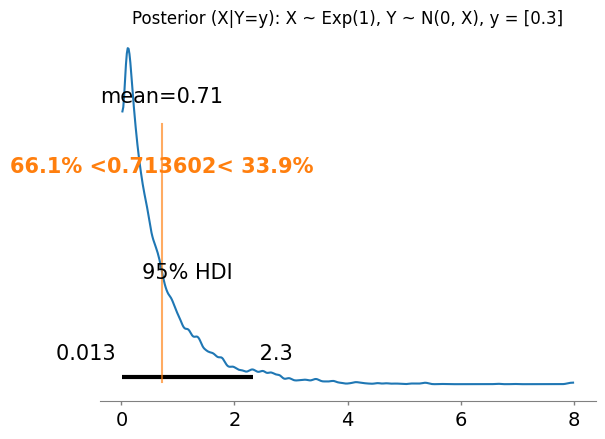

In [15]:
y = [0.3]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    axes = az.plot_posterior({"x": trace["x"]}, hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    plt.show()

Output()

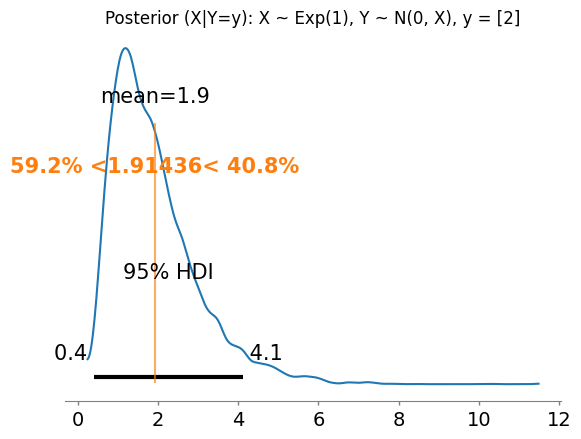

In [16]:
y = [2]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    axes = az.plot_posterior({"x": trace["x"]}, hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    plt.show()

Output()

Output()

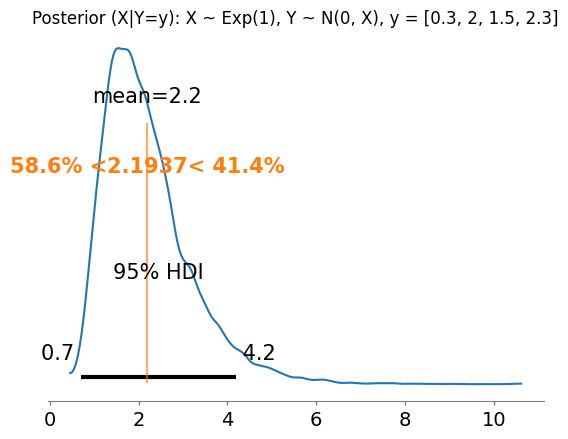

In [17]:
y = [0.3, 2, 1.5, 2.3]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    posterior_pred = pm.sample_posterior_predictive(trace, return_inferencedata=False)
    axes = az.plot_posterior({"x": trace["x"]}, hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    plt.show()

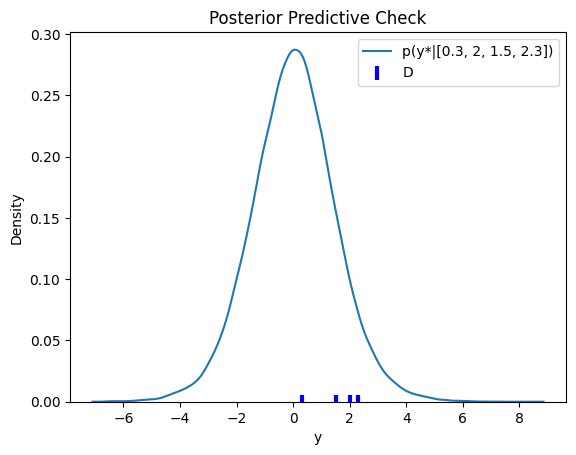

In [18]:
y_post_sample = posterior_pred["y"].flatten()

sns.kdeplot(y_post_sample, label=f"p(y*|{y})")
plt.scatter(y, np.zeros(len(y)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("y")
plt.show()

## <a name="so_sanh"/>So sánh nhóm

### Ví dụ

Bộ dữ liệu Iris

* [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
* [UCI](https://archive.ics.uci.edu/ml/datasets/iris)
* [Scikit-learn](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

In [19]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.feature_names)
print(iris.target_names)
print(iris.data[:5,:])
print(iris.target[:5])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


Biểu đồ hộp của sepal length theo các giống hoa.

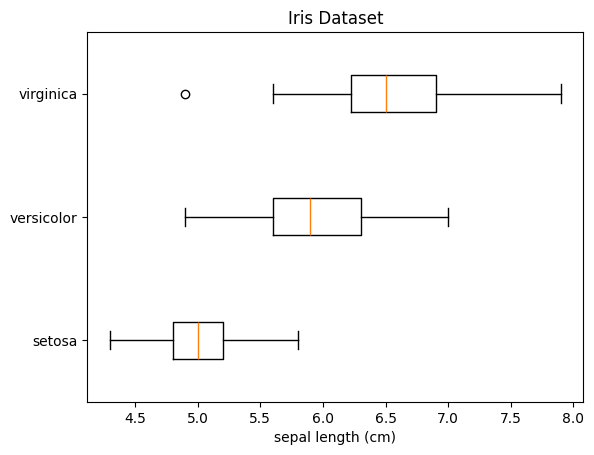

In [20]:
sl_group = [iris.data[iris.target == gr, 0] for gr in range(len(iris.target_names))]
plt.boxplot(sl_group, tick_labels=iris.target_names, orientation="horizontal")
plt.xlabel(iris.feature_names[0])
plt.title("Iris Dataset")
plt.show()

Dùng PyMC so sánh sepal length giữa các giống hoa.

In [21]:
coords = {"species": iris.target_names, "individuals": iris.target_names[iris.target]}
with pm.Model(coords=coords) as model:
  mu = pm.Normal("mu", mu=0, sigma=10, dims="species")
  sigma = pm.HalfNormal("sigma", sigma=10, dims="species")
  y = pm.Normal("y", mu=mu[iris.target], sigma=sigma[iris.target], observed=iris.data[:, 0], dims="individuals")
  idata = pm.sample()
  idata.extend(pm.sample_posterior_predictive(idata))

Output()

Output()

Mô hình

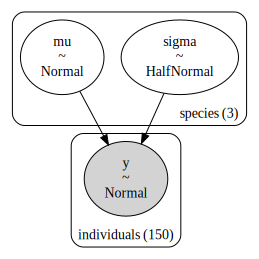

In [22]:
pm.model_to_graphviz(model)

Tóm tắt phân phối hậu nghiệm.

In [23]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[setosa],5.01,0.05,4.90,5.10,0.0,0.0,2656.36,1747.84,1.0
mu[versicolor],5.94,0.07,5.81,6.09,0.0,0.0,2187.27,1647.07,1.0
mu[virginica],6.59,0.09,6.43,6.76,0.0,0.0,2448.81,1733.11,1.0
sigma[setosa],0.36,0.04,0.29,0.43,0.0,0.0,2547.04,1163.88,1.0
sigma[versicolor],0.53,0.05,0.43,0.63,0.0,0.0,2014.91,1572.70,1.0
sigma[virginica],0.65,0.07,0.53,0.78,0.0,0.0,3155.18,1650.59,1.0


Phân phối hậu nghiệm của: hiệu kỳ vọng các nhóm (differences in means), Cohen’s d, và the probability of superiority.

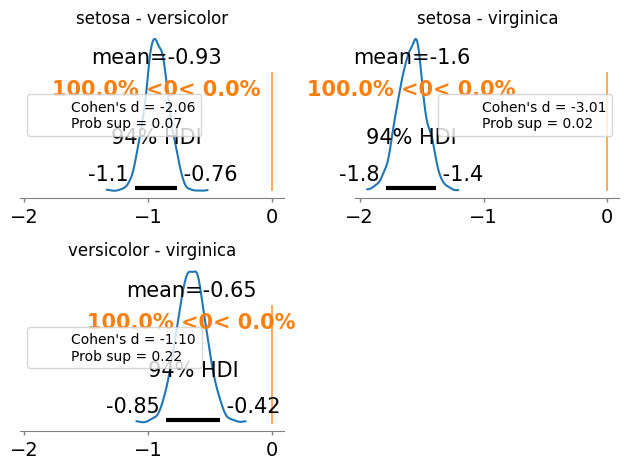

In [24]:
# https://github.com/aloctavodia/BAP3/blob/main/code/Chp_02.ipynb

cg_posterior = az.extract(idata)
dist = stats.norm()
comparisons = [(iris.target_names[i], iris.target_names[j]) for i in range(3) for j in range(i+1, 3)]

_, axes = plt.subplots(2, 2, sharex=True)
for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["mu"].sel(species=i) - cg_posterior["mu"].sel(species=j)

    d_cohen = (means_diff /
               np.sqrt((cg_posterior["sigma"].sel(species=i)**2 +
                        cg_posterior["sigma"].sel(species=j)**2) / 2)
              ).mean().item()

    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend()
axes.flatten()[-1].axis("off")
plt.tight_layout()

Kiểm tra phân phối hậu nghiệm dự đoán.

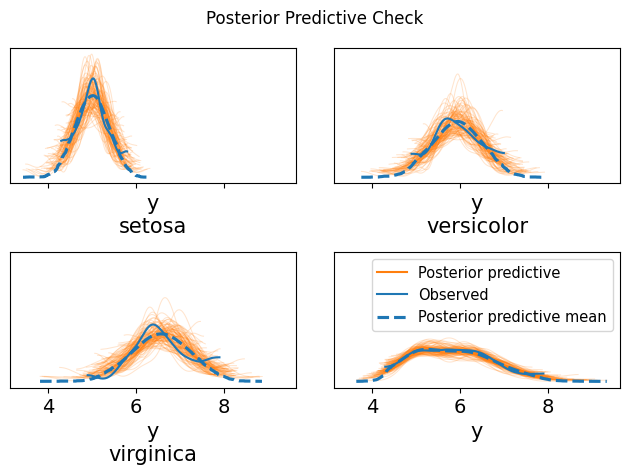

In [25]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C0"], legend=False,
            coords={"individuals": [iris.target_names]}, flatten=[], ax=axes.flatten()[:3])
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C0"],
            coords={"individuals": [iris.target_names]}, ax=axes.flatten()[-1])
fig.suptitle("Posterior Predictive Check")
plt.tight_layout()
plt.show()

## <a name="khang"/>Suy luận kháng ngoại lai

### Ví dụ

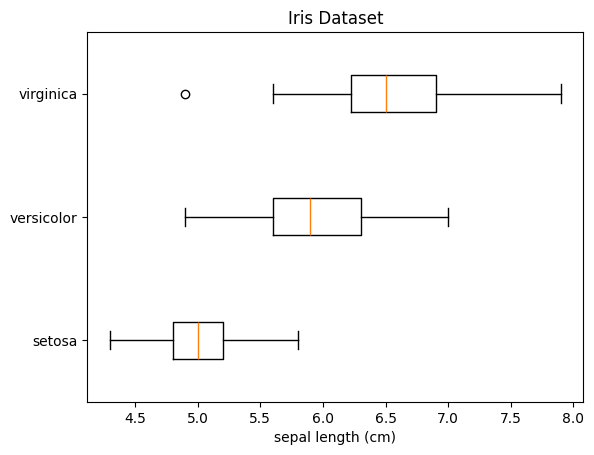

In [26]:
sl_group = [iris.data[iris.target == gr, 0] for gr in range(len(iris.target_names))]
plt.boxplot(sl_group, tick_labels=iris.target_names, orientation="horizontal")
plt.xlabel(iris.feature_names[0])
plt.title("Iris Dataset")
plt.show()

Có ngoại lai trong dữ liệu (vòng tròn trong biểu đồ hộp). Ta dùng mô hình có khả năng kháng ngoại lai, cụ thể là dùng phân phối Student thay cho phân phối chuẩn.

In [27]:
coords = {"species": iris.target_names, "individuals": iris.target_names[iris.target]}
with pm.Model(coords=coords) as model:
  mu = pm.Normal("mu", mu=0, sigma=10, dims="species")
  sigma = pm.HalfNormal("sigma", sigma=10, dims="species")
  nu = pm.Exponential("nu", 1/10, dims="species")
  y = pm.StudentT("y", nu=nu[iris.target], mu=mu[iris.target], sigma=sigma[iris.target], observed=iris.data[:, 0], dims="individuals")
  idata = pm.sample()
  idata.extend(pm.sample_posterior_predictive(idata))

Output()

Output()

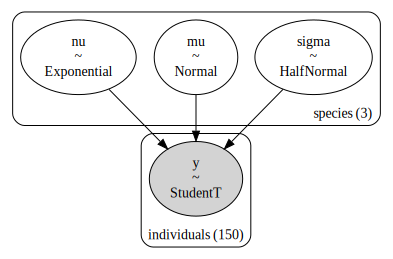

In [28]:
pm.model_to_graphviz(model)

In [29]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[setosa],5.00,0.05,4.91,5.10,0.00,0.00,2457.93,1473.46,1.0
mu[versicolor],5.93,0.08,5.78,6.07,0.00,0.00,2006.53,1297.85,1.0
mu[virginica],6.57,0.09,6.39,6.74,0.00,0.00,2210.04,1425.15,1.0
nu[setosa],16.19,10.90,2.27,36.63,0.22,0.32,2303.88,1670.94,1.0
nu[versicolor],17.42,11.54,3.08,38.91,0.28,0.43,1952.83,1594.26,1.0
nu[virginica],15.36,10.79,1.77,34.02,0.24,0.39,1851.46,1249.87,1.0
sigma[setosa],0.34,0.04,0.26,0.41,0.00,0.00,2007.95,1216.48,1.0
sigma[versicolor],0.50,0.06,0.40,0.62,0.00,0.00,2276.98,1332.84,1.0
sigma[virginica],0.60,0.08,0.45,0.75,0.00,0.00,1942.20,1362.63,1.0


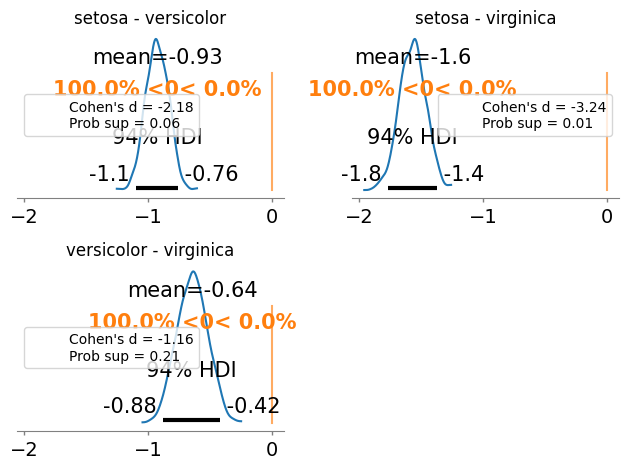

In [30]:
# https://github.com/aloctavodia/BAP3/blob/main/code/Chp_02.ipynb

cg_posterior = az.extract(idata)
dist = stats.norm()
comparisons = [(iris.target_names[i], iris.target_names[j]) for i in range(3) for j in range(i+1, 3)]

_, axes = plt.subplots(2, 2, sharex=True)
for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["mu"].sel(species=i) - cg_posterior["mu"].sel(species=j)

    d_cohen = (means_diff /
               np.sqrt((cg_posterior["sigma"].sel(species=i)**2 +
                        cg_posterior["sigma"].sel(species=j)**2) / 2)
              ).mean().item()

    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend()
axes.flatten()[-1].axis("off")
plt.tight_layout()

Kiểm tra phân phối hậu nghiệm dự đoán.

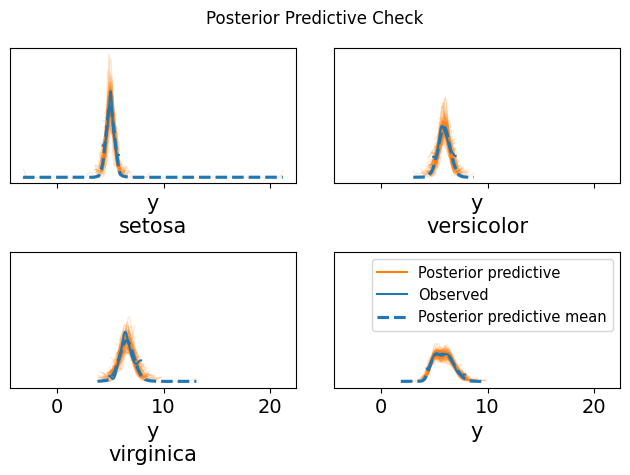

In [31]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C0"], legend=False,
            coords={"individuals": [iris.target_names]}, flatten=[], ax=axes.flatten()[:3])
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C0"],
            coords={"individuals": [iris.target_names]}, ax=axes.flatten()[-1])
fig.suptitle("Posterior Predictive Check")
plt.tight_layout()
plt.show()

## <a name="phan_cap"/>Mô hình phân cấp

### Ví dụ

Trong ví dụ so sánh nhóm, các nhóm được mô hình riêng rẽ.

Dùng mô hình phân cấp, ta giả sử tham số $\mu, \sigma$ của mỗi nhóm được sinh từ cùng một phân phối.

In [32]:
coords = {"species": iris.target_names, "individuals": iris.target_names[iris.target]}
with pm.Model(coords=coords) as model:
  mu_all = pm.HalfNormal("mu_all_mean", sigma=10)
  sigma_all = pm.HalfNormal("sigma_all", sigma=1)
  mu = pm.Normal("mu", mu=mu_all, sigma=10, dims="species")
  sigma = pm.HalfNormal("sigma", sigma=sigma_all, dims="species")
  y = pm.Normal("y", mu=mu[iris.target], sigma=sigma[iris.target], observed=iris.data[:, 0], dims="individuals")
  idata = pm.sample()
  idata.extend(pm.sample_posterior_predictive(idata))

Output()

ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

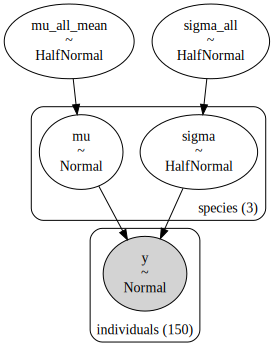

In [33]:
pm.model_to_graphviz(model)

In [34]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[setosa],5.01,0.05,4.91,5.11,0.00,0.00,1993.15,887.70,1.0
mu[versicolor],5.94,0.07,5.80,6.08,0.00,0.00,2252.96,1200.64,1.0
mu[virginica],6.59,0.10,6.41,6.76,0.00,0.00,1950.83,1250.00,1.0
mu_all_mean,6.04,3.78,0.05,12.45,0.11,0.07,1004.14,682.27,1.0
sigma[setosa],0.36,0.04,0.29,0.43,0.00,0.00,1831.52,1220.30,1.0
sigma[versicolor],0.53,0.05,0.43,0.62,0.00,0.00,1968.81,1455.63,1.0
sigma[virginica],0.65,0.07,0.53,0.77,0.00,0.00,2555.32,1553.34,1.0
sigma_all,0.72,0.34,0.27,1.35,0.01,0.01,2320.99,1419.20,1.0


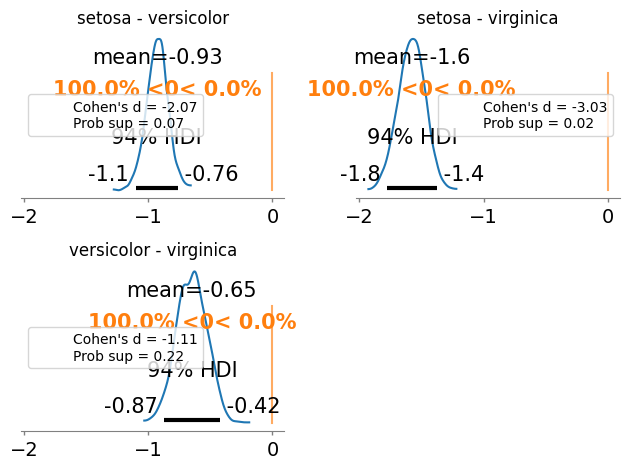

In [35]:
# https://github.com/aloctavodia/BAP3/blob/main/code/Chp_02.ipynb

cg_posterior = az.extract(idata)
dist = stats.norm()
comparisons = [(iris.target_names[i], iris.target_names[j]) for i in range(3) for j in range(i+1, 3)]

_, axes = plt.subplots(2, 2, sharex=True)
for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["mu"].sel(species=i) - cg_posterior["mu"].sel(species=j)

    d_cohen = (means_diff /
               np.sqrt((cg_posterior["sigma"].sel(species=i)**2 +
                        cg_posterior["sigma"].sel(species=j)**2) / 2)
              ).mean().item()

    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend()
axes.flatten()[-1].axis("off")
plt.tight_layout()

Kiểm tra phân phối hậu nghiệm dự đoán.

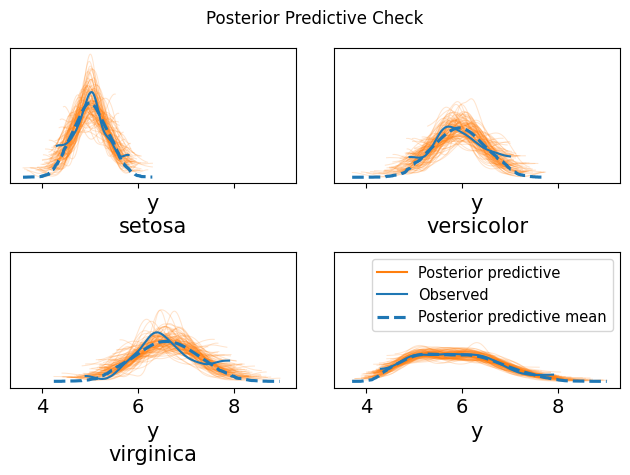

In [36]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C0"], legend=False,
            coords={"individuals": [iris.target_names]}, flatten=[], ax=axes.flatten()[:3])
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C0"],
            coords={"individuals": [iris.target_names]}, ax=axes.flatten()[-1])
fig.suptitle("Posterior Predictive Check")
plt.tight_layout()
plt.show()

## <a name="tuyen_tinh"/>Mô hình tuyến tính tổng quát

### <a name="tt_vd2"/>Ví dụ 1

Hồi qui tuyến tính đơn

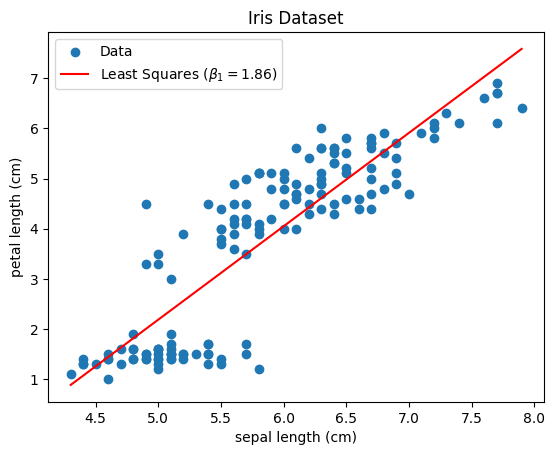

In [37]:
x = iris.data[:, 0]
y = iris.data[:, 2]

res = stats.linregress(x, y)
t = np.linspace(min(x), max(x), 100)
y_linreg = res.intercept + res.slope*t

plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()
plt.show()

Dùng PyMC

In [38]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=1000)
    y_hat = beta_0 + beta_1*x
    y_var = pm.Normal("y", mu=y_hat, sigma=sigma, observed=y)
    trace = pm.sample(5000)

Output()

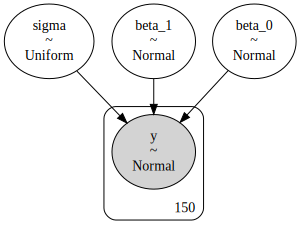

In [39]:
pm.model_to_graphviz(model)

In [40]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-7.07,0.51,-8.06,-6.14,0.01,0.01,3149.13,3636.33,1.0
beta_1,1.85,0.09,1.69,2.01,0.00,0.00,3168.88,3484.54,1.0
sigma,0.88,0.05,0.78,0.97,0.00,0.00,4891.72,4313.56,1.0


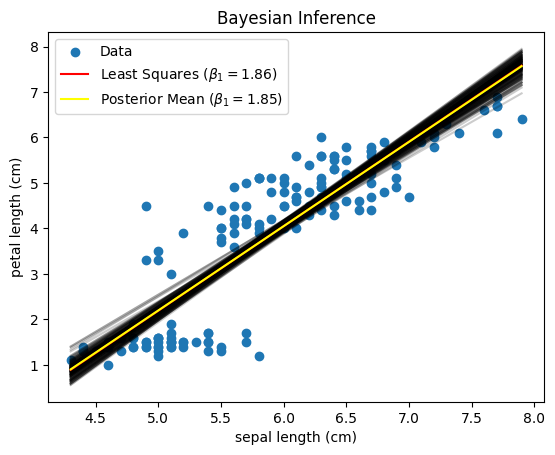

In [41]:
beta_0_trace = np.array(trace.posterior["beta_0"][0])
beta_1_trace = np.array(trace.posterior["beta_1"][0])
sigma_trace = np.array(trace.posterior["sigma"][0])
N = len(beta_0_trace)
for i in np.random.randint(0, N, size=200):
    plt.plot(t, beta_0_trace[i] + beta_1_trace[i]*t, color="black", alpha=0.2)

plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.plot(t, np.mean(beta_0_trace) + np.mean(beta_1_trace)*t, color="yellow",
         label=r"Posterior Mean ($\beta_1 = %.2f$)" % np.mean(beta_1_trace))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()
plt.show()

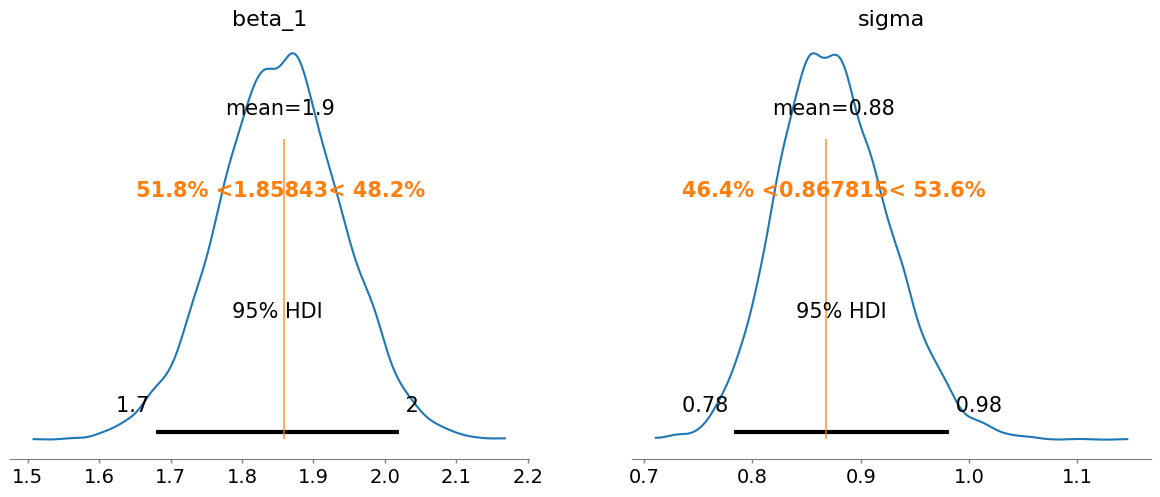

In [42]:
SS_res = np.sum((y - (res.intercept + res.slope*x))**2)
sigma_res = np.sqrt(SS_res/(len(y) - 2))
with model:
    az.plot_posterior(trace, var_names=["beta_1", "sigma"], hdi_prob=0.95, ref_val=[res.slope, sigma_res])
    plt.show()

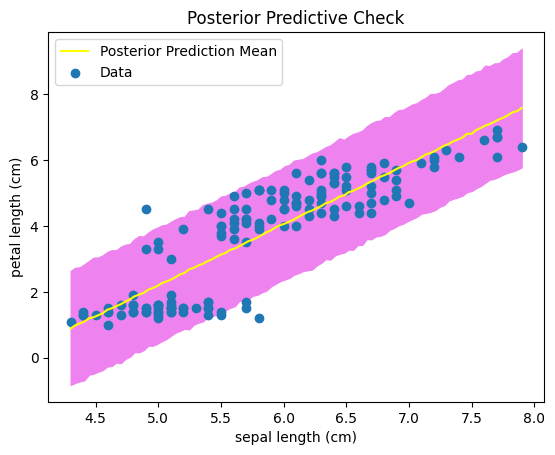

In [43]:
x_test = np.linspace(min(x), max(x), 100)
y_hat_pred = beta_0_trace + beta_1_trace*x_test.reshape((-1,1))
y_pred = np.random.normal(y_hat_pred, sigma_trace)
anpha = 0.05
lower_pred = np.quantile(y_pred, anpha/2, axis=1)
upper_pred = np.quantile(y_pred, 1 - anpha/2, axis=1)
mean_pred = np.mean(y_pred, axis=1)

plt.fill_between(x_test, lower_pred, upper_pred, color="violet")
plt.plot(x_test, mean_pred, color="yellow", label="Posterior Prediction Mean")
plt.scatter(x, y, label="Data")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()

### <a name="tt_vd2"/>Ví dụ 2

Hồi qui logistic

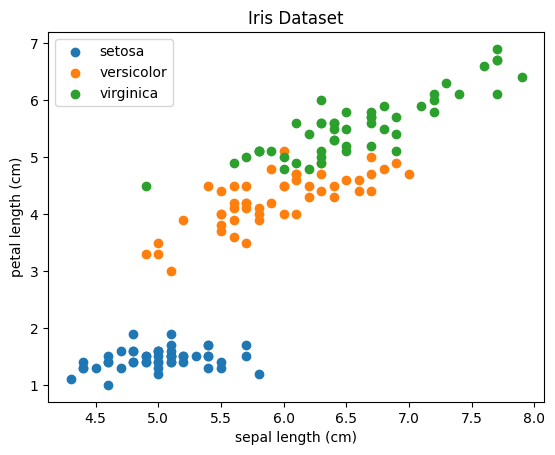

In [44]:
x1 = iris.data[:, 0]
x2 = iris.data[:, 2]
X = np.column_stack((x1, x2))
y = iris.target

for c, c_name in enumerate(iris.target_names):
    plt.scatter(x1[y == c], x2[y == c], label=c_name)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()
plt.show()

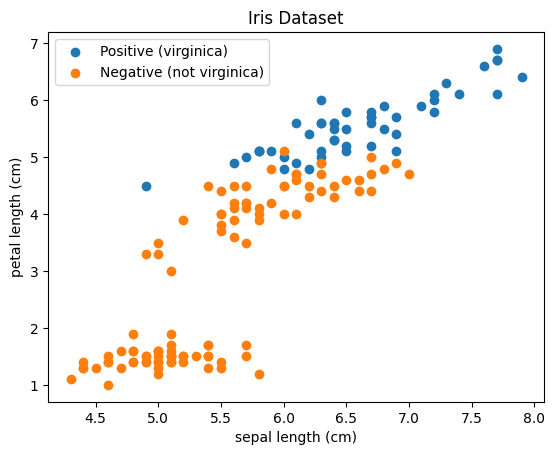

In [45]:
virginica_index = 2
y = (y == virginica_index)

plt.scatter(x1[y], x2[y], label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], label=f"Negative (not {iris.target_names[virginica_index]})")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()
plt.show()

Output()

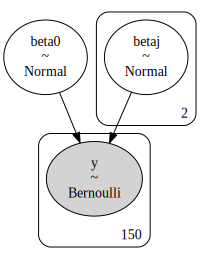

In [46]:
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sigma=2)
    betaj = pm.Normal('betaj', mu=0, sigma=2, shape=X.shape[1])
    p = pm.invlogit(beta0 + pm.math.dot(X, betaj))
    y_var = pm.Bernoulli('y', p, observed=y)
    trace = pm.sample(5000)

pm.model_to_graphviz(model)

In [47]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-3.933,1.698,-7.049,-0.667,0.027,0.022,3884.0,3551.0,1.0
betaj[0],-3.321,0.708,-4.670,-2.016,0.013,0.011,3139.0,3166.0,1.0
betaj[1],5.053,0.830,3.553,6.618,0.015,0.013,3161.0,2865.0,1.0


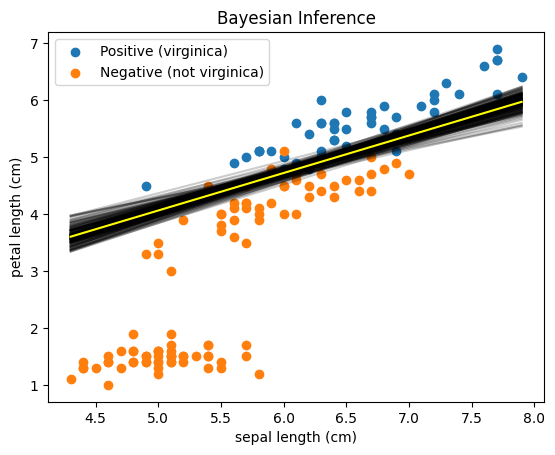

In [48]:
beta0_trace = np.array(trace.posterior["beta0"][0])
betaj_trace = np.array(trace.posterior["betaj"][0])

t = np.linspace(np.min(x1), np.max(x1), 100)
N = len(beta0_trace)
for i in np.random.randint(0, N, size=200):
    beta_0 = beta0_trace[i]
    beta_1 = betaj_trace[i, 0]
    beta_2 = betaj_trace[i, 1]
    plt.plot(t, (-beta_0 - beta_1*t)/beta_2, color="black", alpha=0.2)

plt.scatter(x1[y], x2[y], label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], label=f"Negative (not {iris.target_names[virginica_index]})")
plt.plot(t, (-np.mean(beta0_trace) - np.mean(betaj_trace[:, 0])*t)/np.mean(betaj_trace[:, 1]), color="yellow")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()
plt.show()

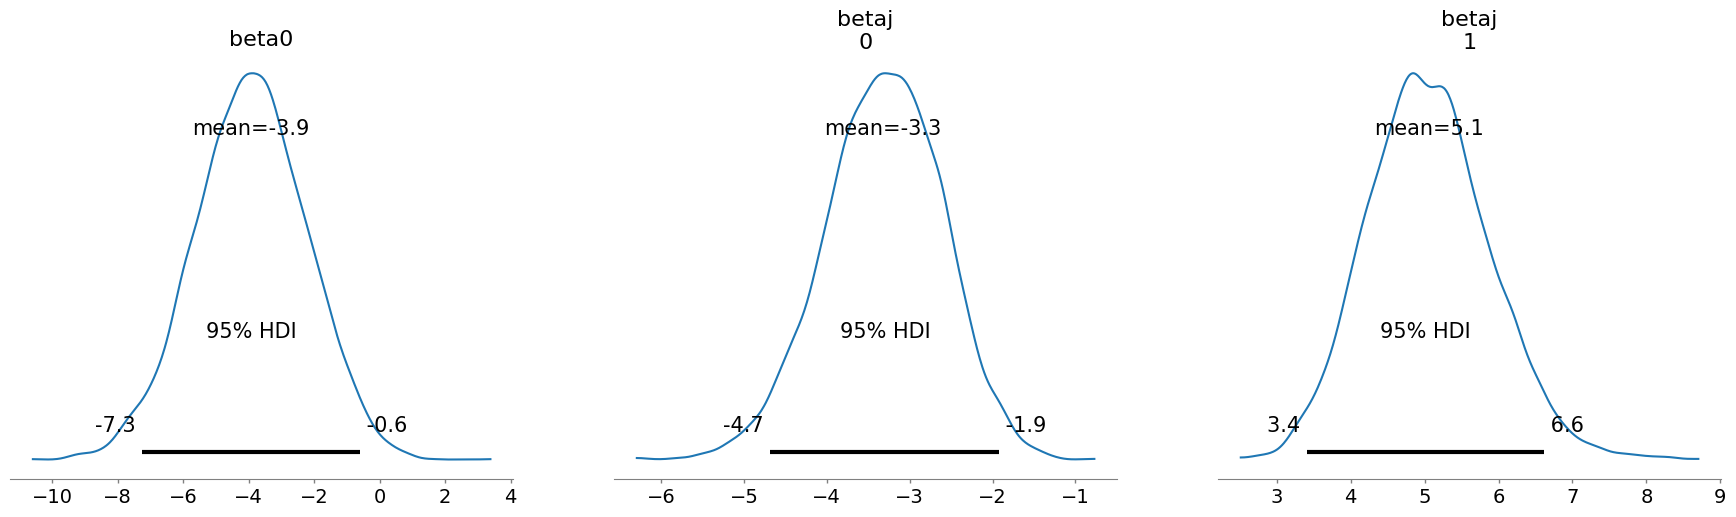

In [49]:
with model:
    az.plot_posterior(trace, var_names=["beta0", "betaj"], hdi_prob=0.95)
    plt.show()

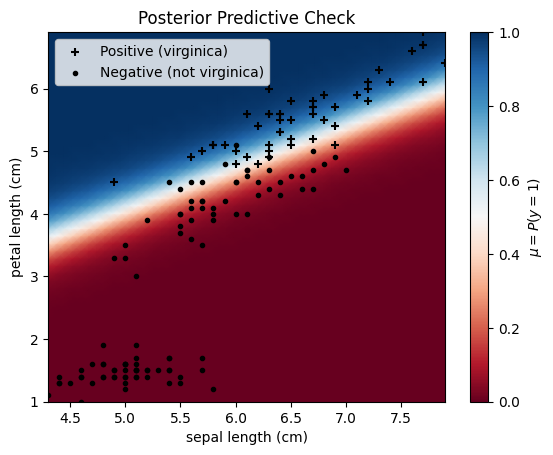

In [50]:
x1_test, x2_test = np.meshgrid(np.linspace(min(x1), max(x1), 50), np.linspace(min(x2), max(x2), 50))

z_pred = beta0_trace + betaj_trace[:,0]*np.expand_dims(x1_test, 2) + betaj_trace[:,1]*np.expand_dims(x2_test, 2)
y_prob_pred = np.mean(1/(1 + np.exp(-z_pred)), axis=2)

c = plt.pcolormesh(x1_test, x2_test, y_prob_pred, cmap="RdBu", vmin=0, vmax=1, shading="gouraud")
plt.colorbar(c, label="$\mu = P(y=1)$")
plt.scatter(x1[y], x2[y], marker="+", color="black",
            label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], marker=".", color="black",
            label=f"Negative (not {iris.target_names[virginica_index]})")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.legend()
plt.title("Posterior Predictive Check")
plt.show()